# Classification of Citrus Leaves with ResNet50
The data is downloaded from [this site](https://data.mendeley.com/datasets/3f83gxmv57/2).

## Custom Dataloader
As the dataset is not included in PyTorch's dataset API, a custom dataset and dataloader can be created from [these instructions](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files
).

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.io import read_image # use PyTorch to read images
import torchvision.transforms as transforms
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [8]:
# constants
IMG_DIR = "./data_citrus_leaves/"
TRAIN_PROPORTION = 0.8
BATCH_SIZE = 32
NUM_EPOCHS = 10
IMAGE_SIZE = (256, 256)
LR = 0.001
RESNET_MEAN = [0.485, 0.456, 0.406]
RESNET_STD = [0.229, 0.224, 0.225]

Here, `RESNET_MEAN` and `RESNET_STD` refer to the mean and standard deviation of the images used to train the ResNet50 model respectively.

In [14]:
# simple encoder to convert `string` to `int`
encoder = {
    "healthy" : 0,
    "black_spot" : 1,
    "canker" : 2,
    "greening" : 3,
    "healthy" : 4,
    "melanose" : 5
}

# class label is name of sub directory, images are in sub directory
class CitrusLeavesDataset(Dataset):
    def __init__(self, img_dir, transform = None, target_transform = None):
        # define main directory of images and transformations
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        # store paths and labels in DataFrame
        data = { "image_path" : [], "label" : [] }
        for sub_dir in os.listdir(img_dir):
            for file in os.listdir(os.path.join(img_dir, sub_dir)):
                data['image_path'].append(os.path.join(img_dir, sub_dir, file))
                data['label'].append(sub_dir)

        # store in annotations
        self.annotations = pd.DataFrame(data)

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        # get image path and label
        image = read_image(self.annotations.iloc[idx, 0]).float()
        label = encoder[self.annotations.iloc[idx, 1]]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [22]:
# transform for training
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.Normalize(mean = RESNET_MEAN, std = RESNET_STD)
])

# inverse transform for plotting
inverse_transform = transforms.Compose([
    transforms.Normalize(
        mean = [0., 0., 0.,],
        std = 
    )
])

data = CitrusLeavesDataset(img_dir = IMG_DIR, transform = transform)

# split data into train and test
train_data, test_data = random_split(
    data,
    [
        int(len(data) * TRAIN_PROPORTION),            # n% of data
        len(data) - int(len(data) * TRAIN_PROPORTION) # rest of data
    ]
)

# create data loaders
train_loader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = True)

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Understanding the Data

In [24]:
# information on dataset
class_names = data.annotations['label'].unique()
print("Classes:", class_names)
print("Length of dataset:", len(data))

Classes: ['black_spot' 'canker' 'greening' 'healthy' 'melanose']
Length of dataset: 609


The dataset contains $609$ images of citrus leaves. The images are in PNG format and have size $256\times256$.

There are five classes: `black_spot`, `canker`, `greening`, `healthy`, and `melanose`.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


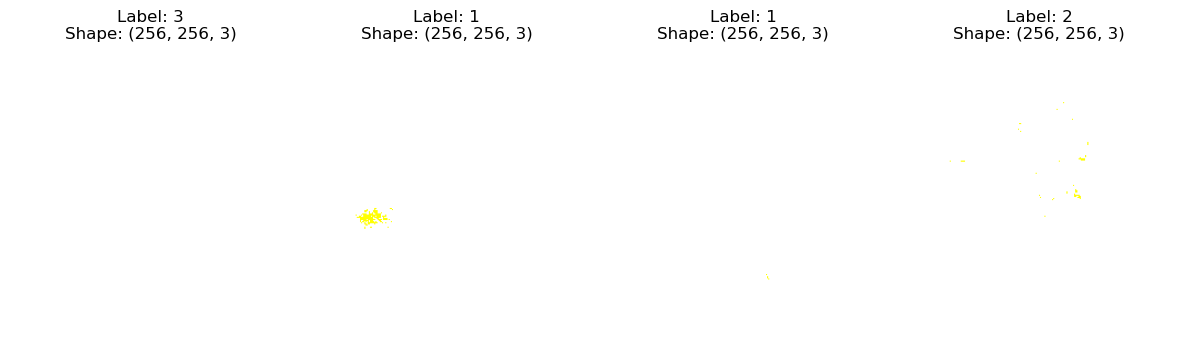

In [30]:
# show random sample images
fig, axes = plt.subplots(1, 4, figsize = (12, 5))
for i in range(4):
    # inverse transform and rearrange dimensions
    image, label = data[np.random.randint(0, len(data))]
    image = inverse_transform(image).numpy().transpose(1, 2, 0)

    # show image
    axes[i].imshow(image)
    axes[i].axis("off")
    axes[i].set_title("Label: {}\nShape: {}".format(label, image.shape))
plt.tight_layout()
plt.show()